In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook

# Function definitions

In [225]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Std dev:",scores.std())

def display_cvgrid_scores(grid_search):
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(mean_score, params)

# Import and split dataset

In [2]:
train_set = pd.read_csv('datasets/mnist_train.csv')
test_set = pd.read_csv('datasets/mnist_test.csv')

In [3]:
X_train = train_set.iloc[:,1:].values
y_train = train_set.iloc[:,0].values

X_test = test_set.iloc[:,1:].values
y_test = test_set.iloc[:,0].values

In [102]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split original dataset in 30% for slower models
split = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
for train_idx, test_idx in split.split(train_set, train_set.label):
    strat_train_set = train_set.loc[train_idx]
    strat_test_set = train_set.loc[test_idx]

strat_X_train = strat_train_set.iloc[:,1:].values
strat_y_train = strat_train_set.iloc[:,0].values

<IPython.core.display.Javascript object>


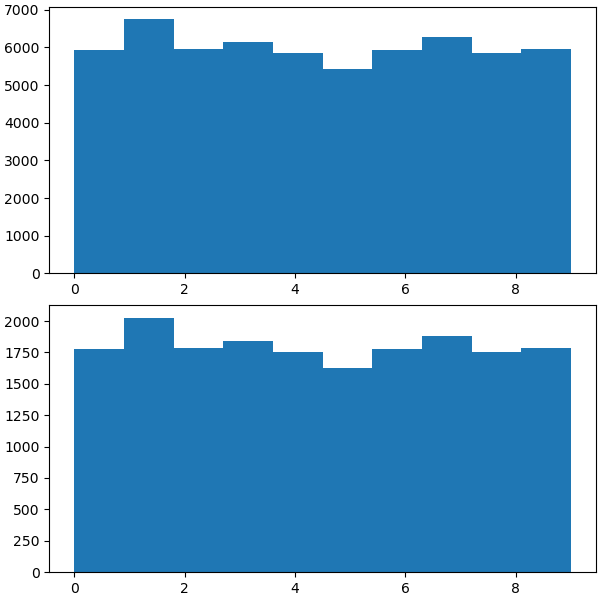

(array([1777., 2023., 1787., 1839., 1753., 1626., 1775., 1880., 1755.,
        1785.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

In [103]:
fig, axs = plt.subplots(2,1,figsize=(6,6),constrained_layout=True)

axs[0].hist(y_train, bins=10)
axs[1].hist(strat_y_train, bins=10)

In [104]:
plt.close()

# Datavis

<IPython.core.display.Javascript object>


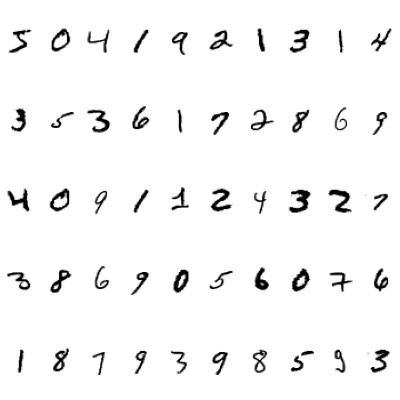

In [140]:
# Show first 25 images

fig, axs = plt.subplots(5,10,figsize=(4,4),constrained_layout=True)

for i,axs in enumerate(axs.flatten()):
    axs.imshow(X_train[i].reshape(28,28), cmap='binary')
    axs.axis('off')
    

In [5]:
plt.close('all')

# Dimensionality reduction

In [128]:
from sklearn.decomposition import PCA

pca = PCA()

In [129]:
%%timeit -r 1 -n 1
pca.fit(strat_X_train)

955 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


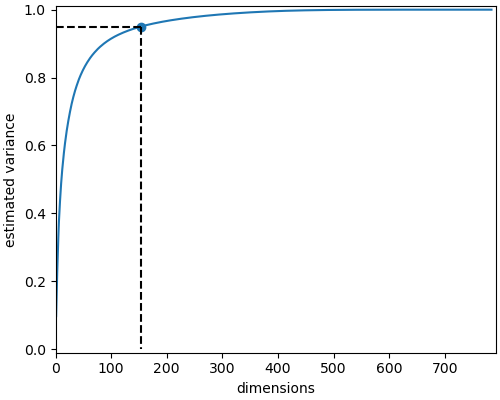

Text(0, 0.5, 'estimated variance')

In [130]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

fig, axs = plt.subplots(1,1,figsize=(5,4),constrained_layout=True)
axs.plot(np.arange(1,cumsum.size+1), cumsum)
axs.scatter([d],[cumsum[d-1]],marker='o')
axs.plot([0,d],[cumsum[d-1],cumsum[d-1]],'k--')
axs.plot([d,d],[cumsum[d-1],0],'k--')
axs.set_ylim([-0.01,1.01])
axs.set_xlim([-0.01,1.01*cumsum.size])
axs.set_xlabel('dimensions')
axs.set_ylabel('estimated variance')

In [131]:
plt.close()

In [287]:
pca = PCA(n_components=d)
strat_X_train_reduced = pca.fit_transform(strat_X_train)
X_train_reduced = pca.fit_transform(X_train)

In [288]:
print(X_train_reduced.shape)
print(strat_X_train_reduced.shape)

(60000, 153)
(18000, 153)


# Models

In [328]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

### SGD Classfier

In [199]:
%%timeit -r 1 -n 1
sgd_scores = cross_val_score(
    SGDClassifier(penalty='l1',alpha=0.01,random_state=42,n_jobs=-1),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=3
)
display_scores(sgd_scores)

Scores: [0.8415     0.83483333 0.84733333]
Mean: 0.8412222222222222
Std dev: 0.005106882308569537
4.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [182]:
%%timeit -r 1 -n 1
sgd_scores = cross_val_score(
    SGDClassifier(random_state=42,n_jobs=-1),
    X_train_reduced,
    y_train,
    scoring = "accuracy",
    cv=3
)
display_scores(sgd_scores)

Scores: [0.8815  0.87785 0.8854 ]
Mean: 0.8815833333333334
Std dev: 0.003082837798018046
15.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [293]:
params_grid = [
    {'penalty': ['l2'], 'alpha':[0.001, 0.01, 0.1, 1.0, 10.00]},
    {'penalty':['elasticnet'], 'l1_ratio':[0.15,0.5,0.85], 'alpha':[0.01]}
]

sgd_clf = SGDClassifier(random_state=42,n_jobs=-1,max_iter=10000)
grid_search = GridSearchCV(
    sgd_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [297]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)

0.8290000000000001 {'alpha': 0.001, 'penalty': 'l2'}
0.8397777777777778 {'alpha': 0.01, 'penalty': 'l2'}
0.8509444444444444 {'alpha': 0.1, 'penalty': 'l2'}
0.8485555555555555 {'alpha': 1.0, 'penalty': 'l2'}
0.7849444444444446 {'alpha': 10.0, 'penalty': 'l2'}
0.8292222222222222 {'alpha': 0.01, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
0.8156666666666667 {'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
0.8250555555555555 {'alpha': 0.01, 'l1_ratio': 0.85, 'penalty': 'elasticnet'}
16.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [302]:
sgd_clf = grid_search.best_estimator_
sgd_acc = grid_search.cv_results_["mean_test_score"].max()
sgd_clf.fit(X_train_reduced, y_train)

array([5])

### K-Neighbors

In [152]:
%%timeit -r 1 -n 1
sgd_scores = cross_val_score(
    KNeighborsClassifier(n_neighbors=3,n_jobs=-1),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=5
)
display_scores(sgd_scores)

Scores: [0.9525     0.95805556 0.95444444 0.95361111 0.95916667]
Mean: 0.9555555555555555
Std dev: 0.002593915006650821
4.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [307]:
params_grid = [
    {'n_neighbors': [1,3,5], 'weights':['uniform','distance']}
]

knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search = GridSearchCV(
    knn_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [308]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)

0.9541111111111111 {'n_neighbors': 1, 'weights': 'uniform'}
0.9541111111111111 {'n_neighbors': 1, 'weights': 'distance'}
0.9534444444444444 {'n_neighbors': 3, 'weights': 'uniform'}
0.9557777777777777 {'n_neighbors': 3, 'weights': 'distance'}
0.9524444444444443 {'n_neighbors': 5, 'weights': 'uniform'}
0.9550555555555555 {'n_neighbors': 5, 'weights': 'distance'}
1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [312]:
knn_clf = grid_search.best_estimator_
knn_acc = grid_search.cv_results_["mean_test_score"].max()
knn_clf.fit(X_train_reduced, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')

### Gaussian Naive Bayes

In [164]:
%%timeit -r 1 -n 1
gnb_scores = cross_val_score(
    GaussianNB(),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=5
)
display_scores(gnb_scores)

Scores: [0.86222222 0.85305556 0.84444444 0.83638889 0.85166667]
Mean: 0.8495555555555555
Std dev: 0.008679122103866692
157 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [343]:
params_grid = [
    {'var_smoothing': np.logspace(-10,-1,10)}
]

gnb_clf = GaussianNB()
grid_search = GridSearchCV(
    gnb_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [344]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)

0.8482222222222222 {'var_smoothing': 1e-10}
0.8482222222222222 {'var_smoothing': 1e-09}
0.8482222222222222 {'var_smoothing': 1e-08}
0.8482222222222222 {'var_smoothing': 1e-07}
0.8483333333333333 {'var_smoothing': 1e-06}
0.8484444444444444 {'var_smoothing': 1e-05}
0.8492777777777777 {'var_smoothing': 0.0001}
0.8558888888888889 {'var_smoothing': 0.001}
0.8378888888888888 {'var_smoothing': 0.01}
0.7519999999999999 {'var_smoothing': 0.1}
3.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [315]:
gnb_clf = grid_search.best_estimator_
gnb_acc = grid_search.cv_results_["mean_test_score"].max()
gnb_clf.fit(X_train_reduced, y_train)

GaussianNB(var_smoothing=0.001)

### Decision tree

In [230]:
%%timeit -r 1 -n 1
tree_scores = cross_val_score(
    DecisionTreeClassifier(splitter='best', max_depth=30),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=5
)
display_scores(tree_scores)

Scores: [0.78333333 0.785      0.77833333 0.77583333 0.77638889]
Mean: 0.7797777777777778
Std dev: 0.0037159981129312506
15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [317]:
params_grid = [
    {'splitter': ['best'], 'max_depth':[10,30,50]},
    {'splitter': ['random'], 'max_depth':[10,30,50]}
]

tree_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(
    tree_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [318]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)

0.767111111111111 {'max_depth': 10, 'splitter': 'best'}
0.7701666666666666 {'max_depth': 30, 'splitter': 'best'}
0.7704444444444444 {'max_depth': 50, 'splitter': 'best'}
0.7211666666666666 {'max_depth': 10, 'splitter': 'random'}
0.7407777777777778 {'max_depth': 30, 'splitter': 'random'}
0.7296666666666667 {'max_depth': 50, 'splitter': 'random'}
24.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [319]:
tree_clf = grid_search.best_estimator_
tree_acc = grid_search.cv_results_["mean_test_score"].max()
tree_clf.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=50)

### SVC

In [173]:
%%timeit -r 1 -n 1

svc_scores = cross_val_score(
    SVC(C=100.0, random_state=42),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=5
)

display_scores(svc_scores)

Scores: [0.97222222 0.97555556 0.9725     0.97111111 0.98      ]
Mean: 0.9742777777777778
Std dev: 0.003218388523991145
24.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [320]:
params_grid = [
    {'kernel': ['rbf'], 'C':[10.0,100.0,1000.0]},
    {'kernel': ['poly'], 'degree':[3], 'C':[10.0,100.0,1000.0]}
]

svc_clf = SVC(random_state=42)
grid_search = GridSearchCV(
    svc_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [253]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)

0.9720555555555556 {'C': 10.0, 'kernel': 'rbf'}
0.972 {'C': 100.0, 'kernel': 'rbf'}
0.972 {'C': 1000.0, 'kernel': 'rbf'}
0.9717777777777777 {'C': 10.0, 'degree': 3, 'kernel': 'poly'}
0.9718333333333334 {'C': 100.0, 'degree': 3, 'kernel': 'poly'}
0.9718333333333334 {'C': 1000.0, 'degree': 3, 'kernel': 'poly'}
2min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [321]:
svc_clf = grid_search.best_estimator_
svc_acc = grid_search.cv_results_["mean_test_score"].max()
svc_clf.fit(X_train_reduced, y_train)

SVC(C=100)

### Random Forest

In [139]:
%%timeit -r 1 -n 1

rf_scores = cross_val_score(
    RandomForestClassifier(n_estimators=500,max_leaf_nodes=20,n_jobs=-1),
    strat_X_train_reduced,
    strat_y_train,
    scoring = "accuracy",
    cv=5
)

display_scores(rf_scores)

Scores: [0.81916667 0.81944444 0.81972222 0.81055556 0.81333333]
Mean: 0.8164444444444443
Std dev: 0.003781860538914995
14.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [271]:
params_grid = [
    {'n_estimators': [500, 1000], 'max_features':['sqrt', 'log2', 10]}
]

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    rf_clf,
    params_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

In [272]:
%%timeit -r 1 -n 1
grid_search.fit(strat_X_train_reduced, strat_y_train)
display_cvgrid_scores(grid_search)
rf_clf = grid_search.best_estimator_

0.9288888888888889 {'max_features': 'sqrt', 'n_estimators': 500}
0.9297777777777778 {'max_features': 'sqrt', 'n_estimators': 1000}
0.9277222222222222 {'max_features': 'log2', 'n_estimators': 500}
0.9308333333333333 {'max_features': 'log2', 'n_estimators': 1000}
0.9292777777777778 {'max_features': 10, 'n_estimators': 500}
0.9305 {'max_features': 10, 'n_estimators': 1000}
1min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [324]:
rf_clf = grid_search.best_estimator_
rf_acc = grid_search.cv_results_["mean_test_score"].max()
rf_clf.fit(X_train_reduced, y_train)

RandomForestClassifier(max_features='log2', n_estimators=1000, n_jobs=-1,
                       random_state=42)

# Compare errors

In [330]:
models = [sgd_clf, knn_clf, gnb_clf, tree_clf, svc_clf, rf_clf]
accs = [sgd_acc, knn_acc, gnb_acc, tree_acc, svc_acc, rf_acc]
preds = []
for model in models:
    print(model)
    preds.append(cross_val_predict(model,X_train_reduced,y_train,cv=3))

SGDClassifier(alpha=0.1, max_iter=10000, n_jobs=-1, random_state=42)
KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')
GaussianNB(var_smoothing=0.001)
DecisionTreeClassifier(max_depth=50)
SVC(C=100)
RandomForestClassifier(max_features='log2', n_estimators=1000, n_jobs=-1,
                       random_state=42)


<IPython.core.display.Javascript object>


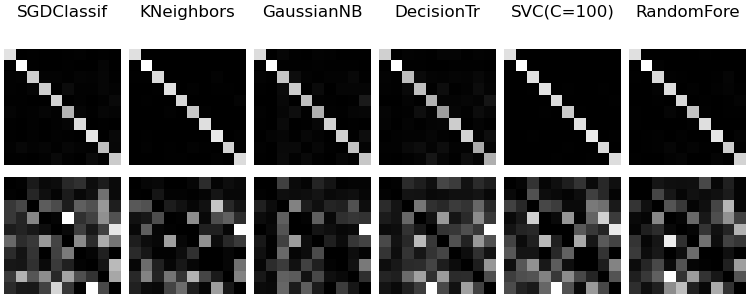

In [342]:
n_models = len(models)
rows = 2
cols = n_models 

fig, axs = plt.subplots(rows, cols, figsize=(7.5,3), constrained_layout=True)

for col in range(cols):
    conf_mx = confusion_matrix(y_train, preds[col])
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    axs[0][col].matshow(conf_mx, cmap=plt.cm.gray)
    axs[1][col].matshow(norm_conf_mx, cmap=plt.cm.gray)
    axs[0][col].set_title(str(models[col])[:10])
    axs[0][col].set_title(str(models[col])[:10])
    
for ax in axs.flatten():
    ax.axis('off')